In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import ptitprince as pt
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import skew, kurtosis
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from IPython.display import display, HTML
pd.options.display.float_format = '{:.3f}'.format


In [22]:
#CLEANING
df = pd.read_csv("Alzheimers Mice Data.csv")
df['AD_Status'] = df['AD_Status'].map({1: 'Transgenic', 2: 'Wild'})
df['Treatment'] = df['Treatment'].map({1: 'Drug 1', 2: 'Drug 2', 3: 'Drug 3', 4: 'Drug 4'})
df.head()

,AD_Status,Treatment,Training,Memory
0,Transgenic,Drug 1,12,10
1,Transgenic,Drug 1,15,12
2,Transgenic,Drug 1,13,13
3,Transgenic,Drug 1,12,10
4,Transgenic,Drug 1,14,13


#### Dataset
Mice are used in an experiment to test drugs that may prevent Alzheimer’s disease. Half the mice are transgenic – have been genetically modified to have Alzheimer’s disease. The other half of the mice are “wild type” – they have not been modified in any way, and are considered free of Alzheimer’s disease. The mice are assigned to treatment conditions and given one of four drugs, then tested on memory using a maze. The number of errors made in the maze is recorded for the Training Day and the Memory Day.

#### Hypotheses
$H_0$: There is no significant interaction effect on memory day errors between drug treatments and AD status. \$H_1$: There is a significant interaction effect on memory day errors between drug treatments and AD status
.
#### Assumptions
**Assumption 1**: You have one dependent variable that is measured at the continuous level. \
Remark: The dependent variable *memory day errors* is measured at the continuous level.

**Assumption 2**: You have two independent variables where each independent variable
consists of two or more categorical, independent groups \
Remark: The independent variables, *treatment* an *AD Status*, are categorical variables. *Treatment* has four independent groups (four different drugs) and *AD status* has two independent groups  transgenic and wild). 

**Assumption 3**: You should have independence of observations. \
Remark: Each case in the dataset is independent with each other as there is no relationship between the cases in each group nor between the groups themselves.

**Assumption 4**: There should be no significant outliers in any cell of the design.


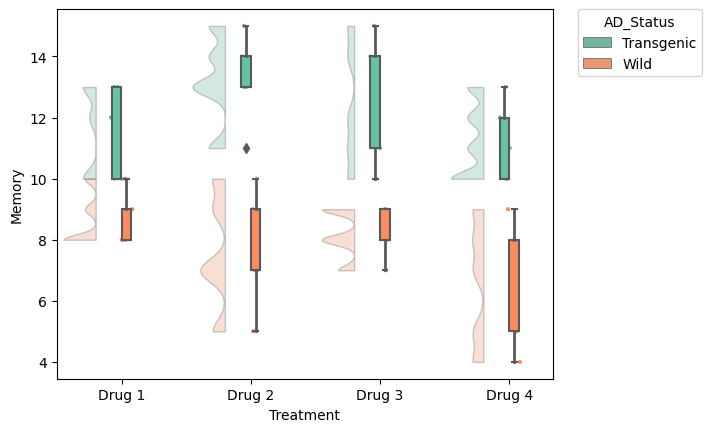

In [23]:

pt.RainCloud(data=df, x='Treatment', y='Memory', hue='AD_Status',
             width_viol=0.5, alpha=0.3, palette='Set2', dodge=True)

plt.show()


Remark: By visual inspection of the plots, there are no significant outliers in any group.

**Assumption 5**: The distribution of the dependent variable (residuals) should be 
approximately normally distributed in every cell of the design.

In [24]:

df_grouped = df.groupby(['AD_Status', 'Treatment'])['Memory']
desc = df_grouped.agg(Valid = 'count', Mean = 'mean', SD = 'std', Skewness = 'skew')
skew_error = lambda x: np.sqrt((6 * len(x) * (len(x)-1))/((len(x)-2) * (len(x)+1) * (len(x)+3)))
skew_stderror = df_grouped.apply(skew_error)
skew_stderror = skew_stderror.to_frame(name='Std. Error of Skewness')
kurt_lambda = lambda x: x.kurtosis()
kurtosis = df_grouped.apply(kurt_lambda)
kurtosis= kurtosis.to_frame(name='Kurtosis')
kurt_error = lambda x: np.sqrt((24 * len(x) * (len(x) - 1) * (len(x) - 1)) / ((len(x) - 3) * (len(x) - 2) * (len(x) + 3) * (len(x) +5)))
kurt_stderror = df_grouped.apply(kurt_error)
kurt_stderror = kurt_stderror.to_frame(name='Std. Error of Kurtosis')
results = {}
for (status, treatment), group in df_grouped:
    stat, p_value = shapiro(group)
    results[(status, treatment)] = (stat, p_value)

shapiro_df = pd.DataFrame(results).transpose().rename(columns={0:'Shapiro', 1:'p-value'})
table_df = pd.concat([desc,skew_stderror, kurtosis, kurt_stderror, shapiro_df], axis=1)
display(HTML("""<h5>Descriptive Statistics</h5>"""))
display(table_df.transpose())


Transgenic                        Wild                \
                           Drug 1 Drug 2 Drug 3 Drug 4 Drug 1 Drug 2 Drug 3   
Valid                       5.000  5.000  5.000  5.000  5.000  5.000  5.000   
Mean                       11.600 13.200 12.400 11.200  8.600  7.600  8.200   
SD                          1.517  1.483  2.074  1.304  0.894  1.949  0.837   
Skewness                   -0.315 -0.552  0.236  0.541  1.258 -0.081 -0.512   
Std. Error of Skewness      0.913  0.913  0.913  0.913  0.913  0.913  0.913   
Kurtosis                   -3.081  0.868 -1.963 -1.488  0.313 -0.817 -0.612   
Std. Error of Kurtosis      2.000  2.000  2.000  2.000  2.000  2.000  2.000   
Shapiro                     0.803  0.956  0.952  0.902  0.771  0.953  0.881   
p-value                     0.086  0.777  0.754  0.421  0.046  0.758  0.314   

                               
                       Drug 4  
Valid                   5.000  
Mean                    6.600  
SD                      2.074  
Skewness               -0.236  
Std. Error of Skewness  0.913  
Kurtosis               -1.963  
Std. Error of Kurtosis  2.000  
Shapiro                 0.952  
p-value                 0.754

Remark: As assessed by Shapiro-Wilk's test for normality, the distribution is normal (p>0.05) for every cell in the design.

**Assumption 6**: The variance of the dependent variable (residuals) should be equal in
every cell of the design

In [25]:
groups = []
for treatment in df['Treatment'].unique():
    for status in df['AD_Status'].unique():
        group_data = df[(df['Treatment'] == treatment) & (df['AD_Status'] == status)]['Memory']
        groups.append(group_data)

stat_levene, p_levene = levene(*groups)

levene_df = pd.DataFrame({
    'F': [stat_levene],
    'df1': [len(df['Treatment'].unique()) * len(df['AD_Status'].unique()) - 1],
    'df2': [len(df) - len(df['Treatment'].unique()) * len(df['AD_Status'].unique())],
    'p': [p_levene]
})

levene_df['F'] = levene_df['F'].round(3)
levene_df['p'] = levene_df['p'].round(3)

display(HTML("""<h5>Test for Equality of Variances (Levene\'s Test)</h5>"""), levene_df)


,F,df1,df2,p
0,0.827,7,32,0.572


Remark: As assessed by Levene's Test for equality of variances, the variances for each combination of the dependent variables are equal (p>0.05).

#### Computation

In [26]:
welch_model = ols('Memory ~ Treatment', data=df).fit()
welch_results = anova_lm(welch_model, typ=2).replace(np.nan, '')

display(HTML("""<h5>Welch's ANOVA</h5>"""), welch_results)

,sum_sq,df,F,PR(>F)
Treatment,14.475,3.000,0.624,0.604
Residual,278.300,36.000,,


In [27]:
welch_model = ols('Memory ~ AD_Status', data=df).fit()
welch_results = anova_lm(welch_model, typ=2).replace(np.nan, '')

display(HTML("""<h5>Welch's ANOVA</h5>"""), welch_results)

,sum_sq,df,F,PR(>F)
AD_Status,189.225,1.000,69.440,0.000
Residual,103.550,38.000,,


Remark: Since p < 0.05, then there is a significant difference in the Memory day errors for each AD Status group.

In [14]:
anova =pg.anova(dv='Memory', between = ['AD_Status', 'Treatment'], data=df)
anova = anova.replace(np.nan, '')
display(HTML("""<h5>Two-Way ANOVA</h5>"""), anova)

,Source,SS,DF,MS,F,p-unc,np2
0,AD_Status,189.225,1,189.225,75.313,0.000,0.702
1,Treatment,14.475,3,4.825,1.920,0.146,0.153
2,AD_Status * Treatment,8.675,3,2.892,1.151,0.344,0.097
3,Residual,80.400,32,2.512,,,


Remark: The results indicate that AD_Status, F(1,32) = 75.313, p =0.000, $\eta^2_p$= 0.153, has a significant effect on Memory Day Errors. There was no significant main effect of Treatment, F(3,32) = 1.920, p =0.146,  $\eta^2_p$ = 0.153 and no significant interaction between AD_Status and Treatment, F(3,32) = 1.151, p = 0.344,  $\eta^2_p$ = 0.097.


In [15]:
tukey = pairwise_tukeyhsd(df['Memory'], df['AD_Status'], alpha=0.05)
tukey_results = tukey.summary().data[1:]
tukey_df = pd.DataFrame(tukey_results, columns=['group1', 'group2', 'Mean Difference', 'p', 'Lower', 'Upper', 'Reject'])

display(HTML("""<h5>Post Hoc Comparisons - AD_Status</h5>"""),tukey_df)

,group1,group2,Mean Difference,p,Lower,Upper,Reject
0,Transgenic,Wild,-4.350,0.000,-5.407,-3.293,True


Remark: Tukey's HSD revealed a significant difference between Transgenic and Wild mice (M = -4.350, p = 0.0), which indicates that the Memory Day errors differed between these groups.